In [311]:
#hide
import rtree
import time
from geopy.distance import geodesic 
from shapely import geometry,wkt,ops
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import neighbors as nb
from scipy import spatial as sp
import matplotlib.pyplot as plt

## Load Map

In [3]:
#hide

mp = pd.read_csv('~/nybb.csv') #loading the bounding polygons
polBor = mp.values
Manhattan = polBor[0, 0]
Manhattan = wkt.loads(Manhattan)

#dividing into subregions 
lonSlice = np.arange(Manhattan.bounds[0], Manhattan.bounds[2], abs(Manhattan.bounds[2] - Manhattan.bounds[0]) / 10)
latSlice = np.arange(Manhattan.bounds[1] , Manhattan.bounds[3] , abs(Manhattan.bounds[2] - Manhattan.bounds[0]) / 10)
Longs = [geometry.LineString([(x , latSlice[0]), (x , latSlice[-1])]) for x in lonSlice]
Lats = [geometry.LineString([(lonSlice[0] , y), (lonSlice[-1] , y)]) for y in latSlice] 
lines = Longs + Lats
for line in lines:
        Manhattan = geometry.MultiPolygon(ops.split(Manhattan, line))


## Loading data and choosing points within the time frame 


In [4]:
#hide
df = pd.read_csv('~/yellow_tripdata_2016-06.csv') #loading
T0 = '2016-06-06 00:00:00'
deltaT = pd.to_datetime(df.tpep_pickup_datetime) - pd.to_datetime(T0)
df['deltaT'] = deltaT // pd.Timedelta('1s')
df.sort_values(by = ['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace = True)
#finding values within wanted timeframe 
X = df.iloc[:, [5, 6, 9, 10, 19]].values
Passengers = df['passenger_count'].values
Passengers = Passengers[np.logical_and(X[:,4]>=0, X[:,4]<7*24*3600)]
X = X [np.logical_and(X[:, 4] >= 0, X[:,4] < 7 * 24 * 3600), :]

## Transformation from [Lon, Lat , sec] to [km ] 

In [502]:
#hide
def metricfun(x, y): 
    R = 6371.009 #radius of earth in km
    
    #determine cartesian for pickup
    pick1 = x[[1, 0]]
    pick2 = y[[1, 0]]
    temp = [x[1], y[0]]
    pickX = R * np.cos(2.0 * np.pi / 360.0 * (pick1[0] + pick2[0]) / 2.0) * (pick1[1]-pick2[1])*(2.0 * np.pi / 360.0)
    pickY = R *(pick1[0] - pick2[0]) * (2.0 * np.pi / 360.0)
    
    #determine cartesian for dropoff
    drop1 = x[[3, 2]]
    drop2 = y[[3, 2]]
    temp = [x[3], y[2]]
    dropX = R * np.cos(2.0 * np.pi / 360.0 * (drop1[0] + drop2[0]) / 2.0) * (drop1[1] - drop2[1]) * (2.0 * np.pi / 360.0)
    dropY = R * (drop1[0] - drop2[0]) * (2 * np.pi / 360)
    
    return  np.hstack([pickX, pickY, dropX, dropY, 4.0 / 3600.0 * np.abs(x[4] - y[4])])

In [6]:
#hide
R = [metricfun(x, X[0,:]) for x in X] # transforming from long lat time -> x,y ,v*t 
#first data point is arbitrarily chosen as the origin
R = np.asarray(R)

## Slicing by the hours

In [202]:
#hide
tInd = np.arange(0,7 * 24 * 3600, 3600) 
tSlices = np.asarray([np.abs(X[:,4] - t).argmin() for t in tInd]) #finding rides withing hourly windows
ridesInSlice = np.diff(tSlices)

## Calculating the KDTree

In [8]:
#hide
tree = nb.KDTree(R, leaf_size=2)  #calculating the KDtree

## Finding Quadrants for pickup and drop off

In [9]:
#hide

N=X.shape[0]
PickQuart = np.zeros([N,])-1
DropQuart = np.zeros([N,])-1
ind = rtree.index.Index() 

for ii, polygon in enumerate(Manhattan): #indexing subregions into rtree
    ind.insert(ii, polygon.bounds)

for ii,x in enumerate(np.asarray(X[0:N, :])): # finding the containing subregion for each of the data point
    #points outside manhatten are marked as -1
    pointPick = geometry.Point(x[0], x[1])
    pointPickBuff = pointPick.buffer(1e-14)
    fids = [int(i) for i in ind.intersection(pointPickBuff.bounds)]
    
    for fid in fids:
        if pointPick.within(Manhattan[fid]):
            PickQuart[ii] = int(fid)
    
    pointDrop = geometry.Point(x[2], x[3])
    pointDropBuff = pointDrop.buffer(1e-14)
    fids = [int(i) for i in ind.intersection(pointDropBuff.bounds)]
    for fid in fids:
        if pointDrop.within(Manhattan[fid]):
            DropQuart[ii] = int(fid)

## Finding the number of pairs in distance < d  for each quadrant

In [326]:
#hide
def corrCompute(tree,Loc,d,Passengers,flag): #calculating the two point correlation function given a tree and set of data
    if Loc.size > 0 :
        if tree is None: #if no overall tree is passed then a tree is built over the subregion
            tree = nb.KDTree(Loc, leaf_size=2) 
        if (flag == 1):  #Normalizing by N^2
            Cn = float(tree.two_point_correlation(Loc, r = d)) / float(Loc.shape[0])**2 #remove **2 for g/N
        elif (flag == 2): #Normalizing by overall possible cars given that each car can fit 6 passengers
            if sum(Passengers!=0)>0:
                Cn = float(tree.two_point_correlation(Loc[Passengers!=0,:], r = d)) / ((np.sum(Passengers[Passengers!=0])/6.0))
            else:
                Cn = np.nan
        else: #no normalization
            Cn = tree.two_point_correlation(Loc, r = d) 
    else:
            Cn = np.nan
    return np.asarray(Cn)

#iterating all time windows and all sub regions to calculate the 2pt correlation
def pairNuminQuad(R,PickQuart,DropQuart,tSlices,d,flag,Passengers,tree = None): 
    QuadNum = int(PickQuart.max())
    Cn = np.zeros([tSlices.shape[0],QuadNum ,QuadNum ])
    #inManhattan = np.logical_and(DropQuart>-1,PickQuart>-1)
    for tt in range(0,tSlices.shape[0]-1):
        tempCord = R[tSlices[tt]:tSlices[tt+1],:]
        tempPickLoc = PickQuart[tSlices[tt]:tSlices[tt+1]]
        tempDropLoc = DropQuart[tSlices[tt]:tSlices[tt+1]]
        tempPassengers = Passengers[tSlices[tt]:tSlices[tt+1]]
        for ii in range(0, QuadNum):
            for jj in range(0, QuadNum):            
                InQuad = np.logical_and(tempPickLoc == ii,tempDropLoc == jj)
                Loc = tempCord[InQuad, :]
                Cn[tt, ii, jj] = corrCompute(tree,Loc,d,tempPassengers[InQuad],flag)
    return Cn

In [327]:
#hide
Cn = []    
flag = 1 #flag value can be changed for different normalizations
Cn.append(pairNuminQuad(R,PickQuart,DropQuart,tSlices,0.5,flag,Passengers,tree))  

In [ ]:
#hide
#calculate the overall 2pt correlation over the entire tree of data points
#Tot = [corrCompute(tree,R[np.logical_and(PickQuart>=0,DropQuart>=0),:],0.5,Passengers[np.logical_and(PickQuart>=0,DropQuart>=0)],flag) for flag in range(0,3)]

In [137]:
# stacking resutls to save as csv
stacked = pd.Panel(Cn[1].swapaxes(1,2)).to_frame().stack().reset_index()
stacked.columns = ['pick up region', 'dropoff region', 't', 'value']
stacked.value
# save to disk
stacked.to_csv('stacked.csv', index=False)


In [71]:
#saving results as pkl
import pickle
pickle.dump([Cn,tree,DropQuart,PickQuart], open( "save.p", "wb" ) )

## Plot figures

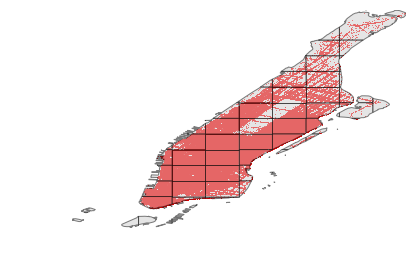

In [175]:
#hide_input
from descartes import PolygonPatch
fig, ax1 = plt.subplots()
temp=X[0:N,:]

for polygon in Manhattan:
    ax1.add_patch(PolygonPatch(polygon,fc ='#cccccc',ec = 'k',  alpha=0.5, zorder=2 ))

ax1.set_xlim(Manhattan.bounds[0],Manhattan.bounds[2])
ax1.set_ylim(Manhattan.bounds[1],Manhattan.bounds[3])
plt.scatter(temp[PickQuart>=0,0],temp[PickQuart>=0,1],s=1, c='r', linewidth=0, zorder=1)
ax1.axis('off')
plt.show()

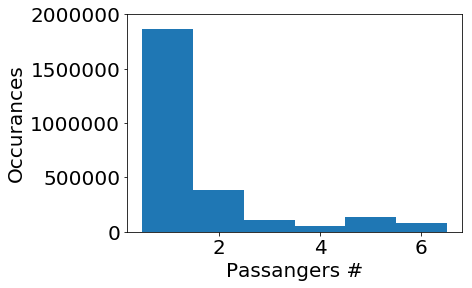

In [171]:
#hide_input
fig = plt.figure()
ax2 = plt.axes()
_ = ax2.hist(np.asarray(Passengers),bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5])
_= ax2.set_ylim(0,2e6)
_=ax2.set_xlabel('Passangers #')
_=ax2.set_ylabel('Occurances')

/home/or/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(-0.5, 103.5, 103.5, -0.5)

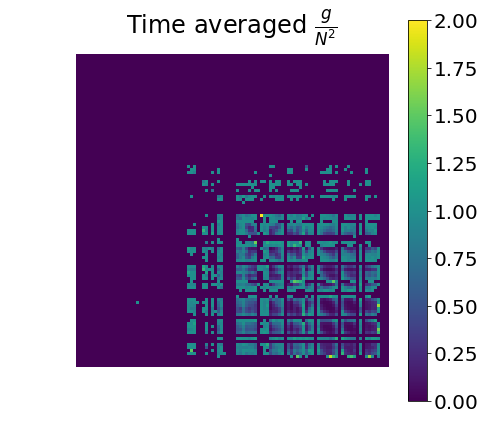

In [498]:
#hide_input
im = np.nanmean(Cn[0][0:-1,:,:],0)
im[np.isnan(im)]=0
fig = plt.figure(figsize=(7,7))
ax = plt.axes()
plt.rc('font', family='sans',size = 20)
plt.imshow(im)#[35::,35::])
plt.clim(0,im.max())
plt.colorbar()
plt.title(r'Time averaged $\frac{g}{N^2}$',y=1.05)
ax.set_xlabel('Pickup quadrant')
ax.set_ylabel('Dropoff quadrant')
ax.axis('off')

28


/home/or/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


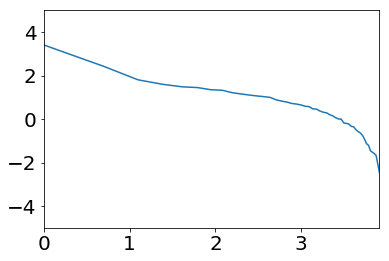

In [492]:
#hide
#SVD over the data from previous cell
fig = plt.figure()
ax = plt.axes()
Temp = np.nanmean(Cn[0][0:-1,:,:],0)
Eig = np.linalg.svd(np.nan_to_num(Temp))
plt.plot(np.log(range(1,Eig[1].size+1)),np.log(Eig[1]))
ax.set_ylim(-5,5)
ax.set_xlim(0,3.9)
sumOfEig = np.asarray([sum(Eig[1][0:ii]) for ii in range(0,Eig[1].size+1)])
VarX09 = np.abs(sumOfEig-0.9*sumOfEig[-1]).argmin()
print(VarX09)

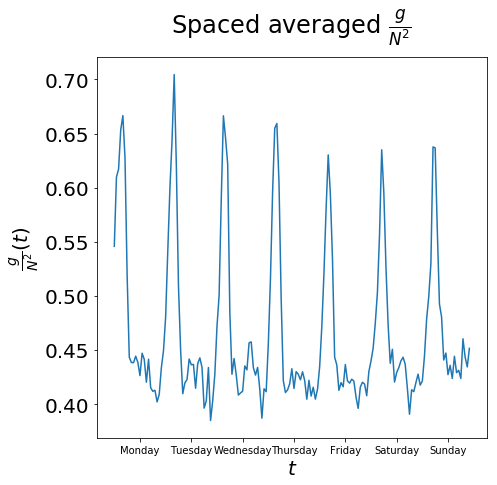

In [500]:
#hide_input
Temp = np.nanmean(Cn[0],(1,2))
fig = plt.figure(figsize = (7,7))
ax = plt.axes()
plt.rc('font', family='sans',size = 20)
#Temp = np.fftf.fftshift(np.fft.fft(Temp[:-1])) to plot in Fourier space
#Temp = np.abs(Temp)
plt.plot(Temp[: -1])
plt.xticks(range(12, 7*24,24))
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],fontsize = 10)
plt.title(r'Spaced averaged $\frac{g}{N^2}$',y=1.05)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$\frac{g}{N^2}(t)$')
plt.show()

/home/or/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


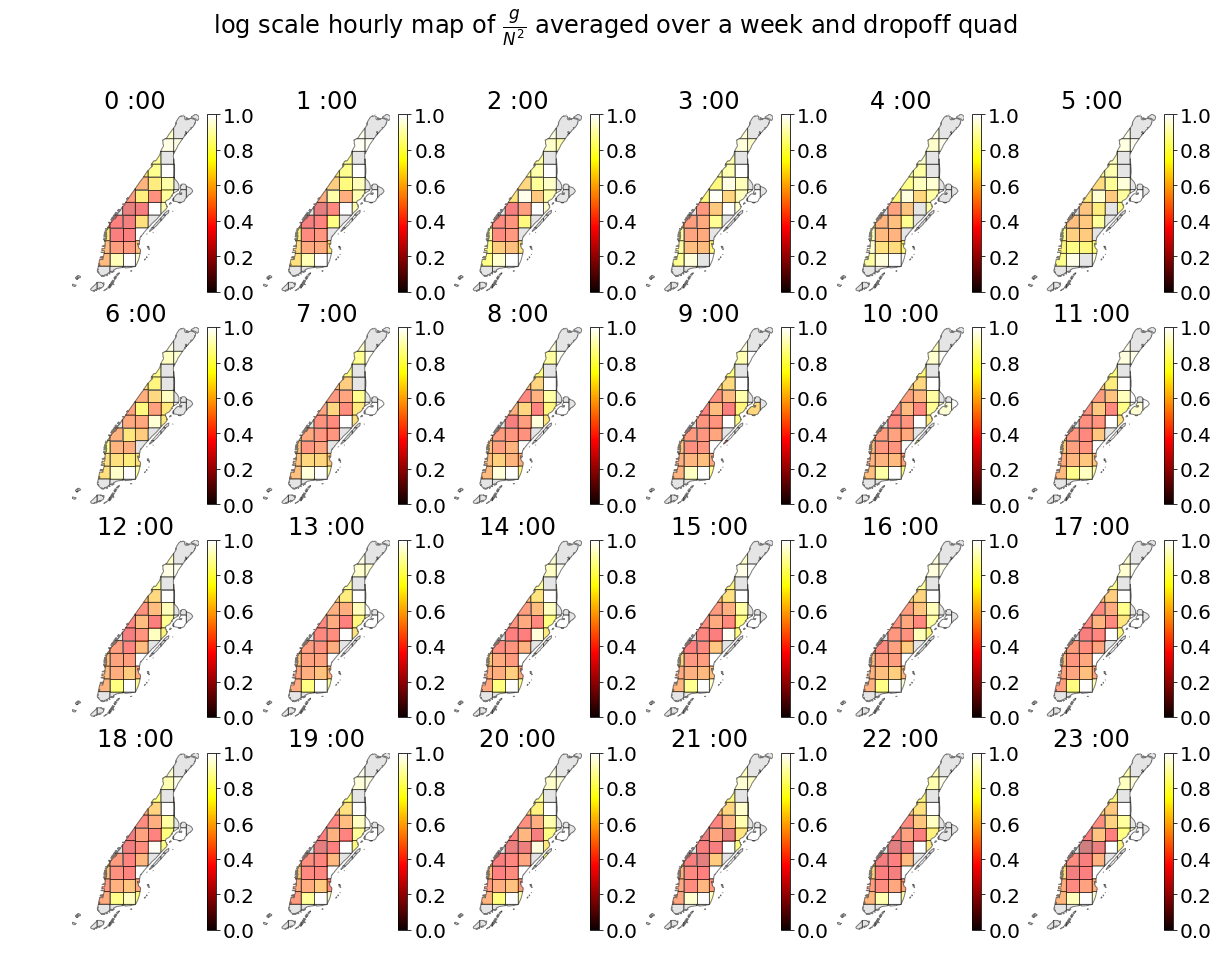

In [501]:
#hide_input
from descartes import PolygonPatch

fig, ax = plt.subplots(ncols = 6,nrows = 4,figsize = (20, 15))
fig.suptitle(r' log scale hourly map of $\frac{g}{N^2}$ averaged over a week and dropoff quad')
for tt in range (0, 24, 1):
        
        TimeSlice = Cn[0][tt:-1:24, :, :]
        TimeSlice = np.nanmean(TimeSlice,0)
        TimeSlice = np.nan_to_num(TimeSlice)
        Pick = np.asarray([np.mean(x[x != 0]) for x in TimeSlice ])
        Pick[np.isnan(Pick)] = 0
        
        cmap=plt.cm.hot
        colorsPick = cmap((Pick))
        norm=plt.Normalize(0,1)
        colorsDrop = cmap((Drop))
        smPick = plt.cm.ScalarMappable(cmap = "hot", norm = plt.Normalize(vmin = 0, vmax = 1))
        smPick.set_array([])
        plt.colorbar(smPick,ax = ax[(tt / 6), tt % 6])
        
        for ii,polygon in enumerate(Manhattan):
            if (Pick[ii-1] == 0):
                ax[tt / 6, tt % 6].add_patch(PolygonPatch(polygon,facecolor = '#cccccc',ec = 'k',  alpha = 0.5, zorder = 2 ))
            else :
                ax[(tt / 6),tt % 6].add_patch(PolygonPatch(polygon,facecolor = colorsPick[ii - 1, :],ec = 'k',  alpha = 0.5, zorder = 2))       
        
        ax[(tt / 6), tt % 6].set_xlim(Manhattan.bounds[0],Manhattan.bounds[2])
        ax[(tt / 6), tt % 6].set_ylim(Manhattan.bounds[1],Manhattan.bounds[3])
        ax[(tt / 6), tt % 6].axis('off')
        ax[(tt / 6), tt % 6].set_title("%i :00" % tt)
plt.show()


/home/or/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


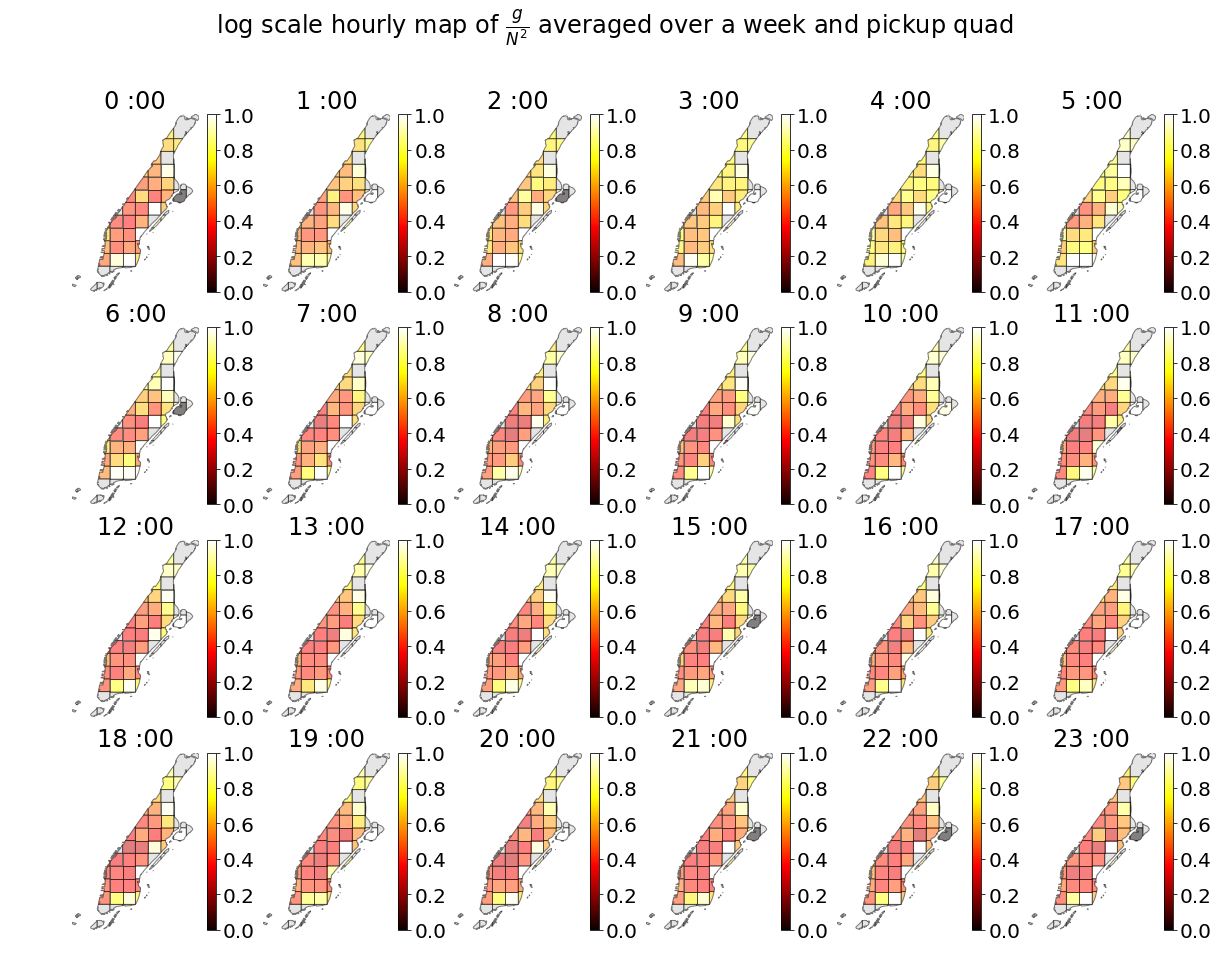

In [354]:
#hide_input
from descartes import PolygonPatch

cmap = plt.get_cmap('cool')
QuadNum = int(PickQuart.max())    
fig, ax = plt.subplots(ncols = 6,nrows = 4,figsize = (20, 15))
fig.suptitle(r' log scale hourly map of $\frac{g}{N^2}$ averaged over a week and pickup quad')
for tt in range (0, 24, 1):
        TimeSlice = Cn[0][tt:-1:24, :, :]
        TimeSlice = np.nanmean(TimeSlice,0)
        TimeSlice = np.nan_to_num(TimeSlice)
        Drop = np.asarray([np.mean(x[x != 0]) for x in TimeSlice.transpose()])
        Drop[np.isnan(Drop)] = 0
        
        cmap=plt.cm.hot
        norm=plt.Normalize(0,1)
        colorsDrop = cmap((Drop))
        smDrop = plt.cm.ScalarMappable(cmap = "hot", norm=plt.Normalize(vmin = 0, vmax = 1))
        smDrop.set_array([])
        plt.colorbar(smDrop,ax = ax[(tt / 6), tt % 6])
        
        for ii,polygon in enumerate(Manhattan):
            if (Pick[ii-1] == 0):
                ax[tt / 6, tt % 6].add_patch(PolygonPatch(polygon,facecolor = '#cccccc',ec = 'k',  alpha = 0.5, zorder = 2 ))
            else :
                ax[(tt / 6),tt % 6].add_patch(PolygonPatch(polygon,facecolor = colorsDrop[ii - 1, :],ec = 'k',  alpha = 0.5, zorder = 2))       
        
        ax[(tt / 6), tt % 6].set_xlim(Manhattan.bounds[0],Manhattan.bounds[2])
        ax[(tt / 6), tt % 6].set_ylim(Manhattan.bounds[1],Manhattan.bounds[3])
        ax[(tt / 6), tt % 6].axis('off')
        ax[(tt / 6), tt % 6].set_title("%i :00" % tt)
plt.show()


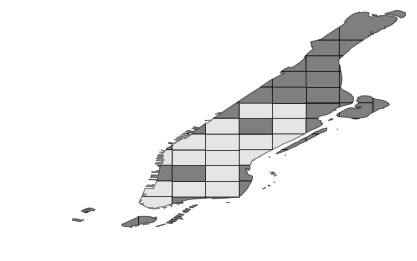

In [454]:
#hide
stacked = pd.Panel(Cn[0].swapaxes(1,2)).to_frame().stack().reset_index()
stacked.columns = ['x', 'y', 't', r'$\frac{g}{N^2}$']
stacked.sort_values(by = [r'$\frac{g}{N^2}$'], inplace = True,ascending=False)
top = stacked[0:100].values
fig, ax = plt.subplots()
        
for ii,polygon in enumerate(Manhattan):
    if np.sum(top[:,0]==ii)>0:
        ax.add_patch(PolygonPatch(polygon,facecolor = '#cccccc',ec = 'k',  alpha = 0.5, zorder = 2 ))
    else:
        ax.add_patch(PolygonPatch(polygon,facecolor = 'k',ec = 'k',  alpha = 0.5, zorder = 2 ))

ax.set_xlim(Manhattan.bounds[0],Manhattan.bounds[2])
ax.set_ylim(Manhattan.bounds[1],Manhattan.bounds[3])
ax.axis('off')
plt.show()


In [ ]:
#hide
from scipy.stats import norm
norm.ppf(1-0.05/2)**2*(0.3315*(1-0.3315))/0.1075**2